In [1]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
#import pandas as pd
#from rasterio.crs import CRS
#from rasterio.transform import from_origin
from matplotlib import gridspec
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import geojson
import matplotlib
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import subprocess
import firedrake
import icepack
import math
import icepack.plot
from firedrake import assemble, Constant, inner, grad, dx
from icepack.statistics import (
    StatisticsProblem,
    MaximumProbabilityEstimator,
)
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# viscosity
visc_pre_calving_in  = '/home/sermilik/brunt_model/d01_pre_calving/model_viscosity_pre_calving_err5_T253_steptol_1Eneg2.tif'
visc_calving_in      = '/home/sermilik/brunt_model/d02_calving/model_viscosity_calving_err5_T253_steptol_1Eneg2.tif'
visc_post_calving_in = '/home/sermilik/brunt_model/d03_post_calving/model_viscosity_post_calving_err5_T253_steptol_1Eneg2.tif'

visc_pre_calving_open  = rasterio.open(visc_pre_calving_in)
visc_calving_open      = rasterio.open(visc_calving_in)
visc_post_calving_open = rasterio.open(visc_post_calving_in)

visc_pre_calving = visc_pre_calving_open.read(1)
visc_calving = visc_calving_open.read(1)
visc_post_calving = visc_post_calving_open.read(1)

#show(visc_pre_calving)
#show(visc_calving)
#show(visc_post_calving)

D_calving = 100*(visc_calving - visc_pre_calving) / visc_pre_calving
D_post_calving = 100*(visc_post_calving - visc_pre_calving) / visc_pre_calving

#fluidity
fluid_pre_calving_in = '/home/sermilik/brunt_model/d01_pre_calving/model_fluidity_pre_calving_err5_T253_steptol_1Eneg2.tif'
fluid_calving_in = '/home/sermilik/brunt_model/d02_calving/model_fluidity_calving_err5_T253_steptol_1Eneg2.tif'

fluid_pre_calving_open = rasterio.open(fluid_pre_calving_in)
fluid_calving_open = rasterio.open(fluid_calving_in)

fluid_pre_calving = fluid_pre_calving_open.read(1)
fluid_calving = fluid_calving_open.read(1)



F_calving = 100*(fluid_calving - fluid_pre_calving) / fluid_pre_calving




In [3]:
#pre-calving Landsat-8

landsat_B2_pre_out = "/home/sermilik/brunt_model/imagery/pre_calving/LC08_L1GT_184113_184114_20200220_B2_merge_crop.tif"
landsat_B3_pre_out = "/home/sermilik/brunt_model/imagery/pre_calving/LC08_L1GT_184113_184114_20200220_B3_merge_crop.tif"
landsat_B4_pre_out = "/home/sermilik/brunt_model/imagery/pre_calving/LC08_L1GT_184113_184114_20200220_B4_merge_crop.tif"

landsat_B2_pre_merged = rasterio.open(landsat_B2_pre_out)
landsat_B3_pre_merged = rasterio.open(landsat_B3_pre_out)   
landsat_B4_pre_merged = rasterio.open(landsat_B4_pre_out)    

ls_B2_pre_merged = landsat_B2_pre_merged.read(1)
ls_B2_pre_merged[ls_B2_pre_merged > np.percentile(ls_B2_pre_merged,99)] = np.percentile(ls_B2_pre_merged,99)
ls_B3_pre_merged = landsat_B3_pre_merged.read(1)
ls_B3_pre_merged[ls_B3_pre_merged > np.percentile(ls_B3_pre_merged,99)] = np.percentile(ls_B3_pre_merged,99)   
ls_B4_pre_merged = landsat_B4_pre_merged.read(1)
ls_B4_pre_merged[ls_B4_pre_merged > np.percentile(ls_B4_pre_merged,99)] = np.percentile(ls_B4_pre_merged,99)    

ls_pre_merged = np.array([ls_B2_pre_merged, ls_B3_pre_merged, ls_B4_pre_merged]).transpose(1,2,0)
ls_pre_merged_norm = (ls_pre_merged * (255 / np.max(ls_pre_merged))).astype(np.uint8)

In [4]:
#calving Sentinel-2

sentinel_out_B2_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B2_ps_merge_crop.tif'
sentinel_out_B3_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B3_ps_merge_crop.tif'
sentinel_out_B4_ps = '/home/sermilik/brunt_model/imagery/calving/20210314T100059_B4_ps_merge_crop.tif'
              
img1_2 = rasterio.open(sentinel_out_B2_ps)
img1_3 = rasterio.open(sentinel_out_B3_ps)
img1_4 = rasterio.open(sentinel_out_B4_ps)

#crop to 99th percentile (stops dull images)
image1_2 = img1_2.read(1)
image1_2[image1_2 > np.percentile(image1_2,99)] = np.percentile(image1_2,99)
image1_3 = img1_3.read(1)
image1_3[image1_3 > np.percentile(image1_3,99)] = np.percentile(image1_3,99)
image1_4 = img1_4.read(1)
image1_4[image1_4 > np.percentile(image1_4,99)] = np.percentile(image1_4,99)

image1 = np.array([image1_2, image1_3, image1_4]).transpose(1,2,0)
s2_calve_norm1 = (image1 * (255 / np.max(image1))).astype(np.uint8)

In [5]:
#post-calving Landsat-8

landsat_B2_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B2_merge_crop.tif"
landsat_B3_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B3_merge_crop.tif"
landsat_B4_post_out = "/home/sermilik/brunt_model/imagery/post_calving/LC08_L1GT_184113_184114_20211020_B4_merge_crop.tif"

landsat_B2_post_merged = rasterio.open(landsat_B2_post_out)
landsat_B3_post_merged = rasterio.open(landsat_B3_post_out)   
landsat_B4_post_merged = rasterio.open(landsat_B4_post_out)    

ls_B2_post_merged = landsat_B2_post_merged.read(1)
ls_B2_post_merged[ls_B2_post_merged > np.percentile(ls_B2_post_merged,99)] = np.percentile(ls_B2_post_merged,99)
ls_B3_post_merged = landsat_B3_post_merged.read(1)
ls_B3_post_merged[ls_B3_post_merged > np.percentile(ls_B3_post_merged,99)] = np.percentile(ls_B3_post_merged,99)   
ls_B4_post_merged = landsat_B4_post_merged.read(1)
ls_B4_post_merged[ls_B4_post_merged > np.percentile(ls_B4_post_merged,99)] = np.percentile(ls_B4_post_merged,99)    

ls_post_merged = np.array([ls_B2_post_merged, ls_B3_post_merged, ls_B4_post_merged]).transpose(1,2,0)
ls_post_merged_norm = (ls_post_merged * (255 / np.max(ls_post_merged))).astype(np.uint8)

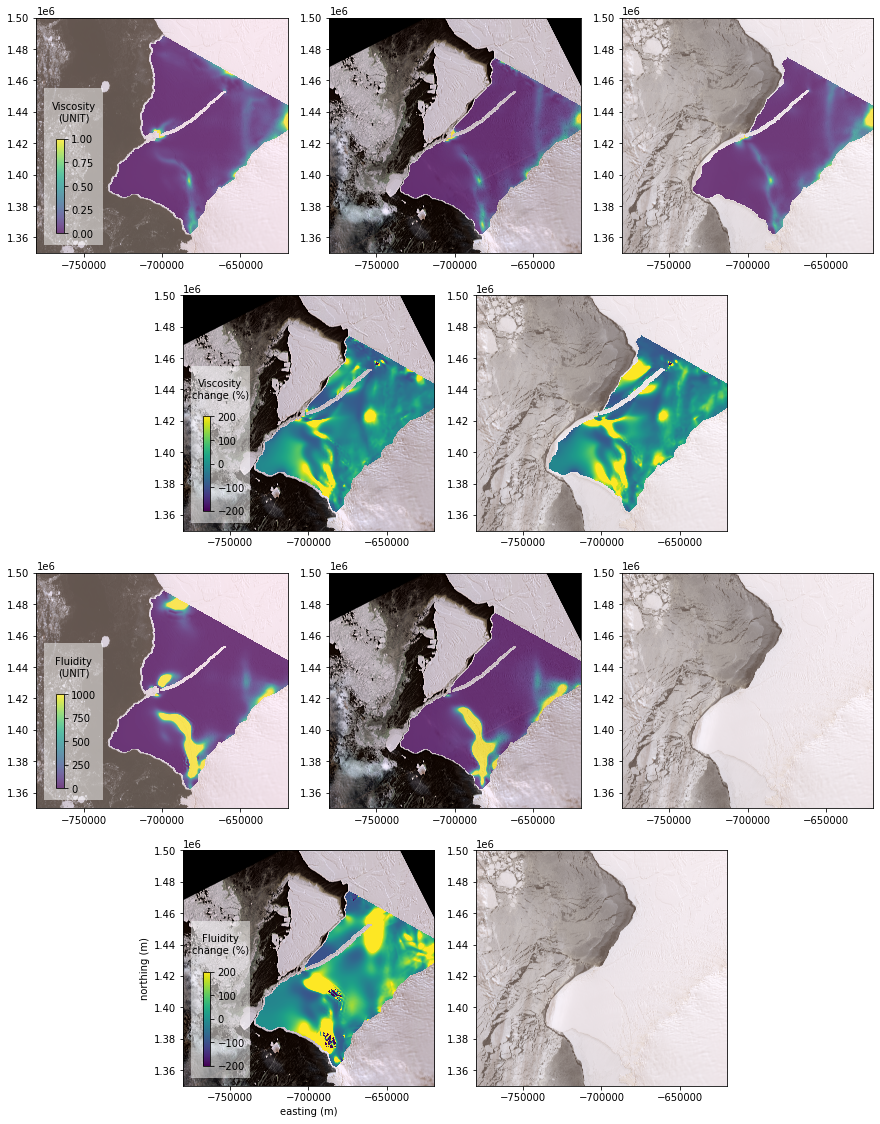

In [7]:
gr = 0.4
vvmin = 0
vvmax = 1200
vdmin = -500
vdmax = 500

viscmin = 0
viscmax = 1
viscdmin = -200
viscdmax = 200

fluidmin=0
fluidmax=1000
fluiddiffmin=-200
fluiddiffmax=200

xmin = -780000
xmax = -620000 #160000 wide
ymin = 1350000 
ymax = 1500000 #150000 tall

fig = plt.figure(figsize=(15, 20))

gs = gridspec.GridSpec(8, 6, wspace=0.4)


#--------------------------------------------------
ax6 = plt.subplot(gs[0:2,0:2])
hidden_visc = ax6.imshow(fluid_pre_calving,alpha=0.75,vmin=viscmin,vmax=viscmax)
show(ls_pre_merged_norm.transpose(2,0,1), transform=landsat_B2_pre_merged.transform, ax=ax6)
show(visc_pre_calving,ax=ax6,transform=visc_pre_calving_open.transform,alpha=0.75,vmin=viscmin,vmax=viscmax)
        
ax6.add_patch(Rectangle((-775000,1355000),37500,100000,edgecolor = 'none',facecolor = 'white',alpha = 0.5))
cbaxes6 = inset_axes(ax6, width="3%", height="40%",loc='lower left',borderpad=2)
cbar6 = plt.colorbar(hidden_visc,cax=cbaxes6) #, ticks=[-500,-250,0,250,500],extend='both')
ax6.annotate("Viscosity\n(UNIT)",(-775000+(37500/2),1440000),size=10,ha='center',va='center')        

ax7 = plt.subplot(gs[0:2,2:4])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax7)
show(visc_calving,ax=ax7,transform=visc_calving_open.transform,alpha=0.75,vmin=viscmin,vmax=viscmax)

ax8 = plt.subplot(gs[0:2,4:6])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax8)
show(visc_post_calving,ax=ax8,transform=visc_post_calving_open.transform,alpha=0.75,vmin=viscmin,vmax=viscmax)

#--------------------------------------------------
ax22 = plt.subplot(gs[2:4,1:3])
hidden_viscdif22 = ax22.imshow(D_calving,vmin=viscdmin,vmax=viscdmax)
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax22)
show(D_calving, transform=visc_pre_calving_open.transform, ax=ax22,vmin=viscdmin,vmax=viscdmax)

ax22.add_patch(Rectangle((-775000,1355000),37500,100000,edgecolor = 'none',facecolor = 'white',alpha = 0.5))
cbaxes22 = inset_axes(ax22, width="3%", height="40%",loc='lower left',borderpad=2)
cbar22 = plt.colorbar(hidden_viscdif22, cax=cbaxes22) 
ax22.annotate("Viscosity\nchange (%)",(-775000+(37500/2),1440000),size=10,ha='center',va='center')        

ax23 = plt.subplot(gs[2:4,3:5])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax23)
show(D_post_calving, transform=visc_pre_calving_open.transform, ax=ax23,vmin=viscdmin,vmax=viscdmax)






#--------------------------------------------------
ax9 = plt.subplot(gs[4:6,0:2])
hidden_fluid = ax9.imshow(fluid_pre_calving,alpha=0.75,vmin=fluidmin,vmax=fluidmax)
show(ls_pre_merged_norm.transpose(2,0,1), transform=landsat_B2_pre_merged.transform, ax=ax9)
show(fluid_pre_calving,ax=ax9,transform=fluid_pre_calving_open.transform,alpha=0.75,vmin=fluidmin,vmax=fluidmax)
        
ax9.add_patch(Rectangle((-775000,1355000),37500,100000,edgecolor = 'none',facecolor = 'white',alpha = 0.5))
cbaxes9 = inset_axes(ax9, width="3%", height="40%",loc='lower left',borderpad=2)
cbar9 = plt.colorbar(hidden_fluid,cax=cbaxes9) #, ticks=[-500,-250,0,250,500],extend='both')
ax9.annotate("Fluidity\n(UNIT)",(-775000+(37500/2),1440000),size=10,ha='center',va='center')        

ax10 = plt.subplot(gs[4:6,2:4])
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax10)
show(fluid_calving,ax=ax10,transform=fluid_calving_open.transform,alpha=0.75,vmin=fluidmin,vmax=fluidmax)

ax11 = plt.subplot(gs[4:6,4:6])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax11)
#show(visc_post_calving,ax=ax11,transform=visc_post_calving_open.transform,alpha=0.75,vmin=viscmin,vmax=viscmax)

#--------------------------------------------------
ax20 = plt.subplot(gs[6:8,1:3])
hidden_fluiddiff20 = ax20.imshow(F_calving,vmin=fluiddiffmin,vmax=fluiddiffmax)
show(s2_calve_norm1.transpose(2,0,1), transform=img1_2.transform, ax=ax20)
show(F_calving, transform=fluid_calving_open.transform, ax=ax20,vmin=fluiddiffmin,vmax=fluiddiffmax)

ax20.add_patch(Rectangle((-775000,1355000),37500,100000,edgecolor = 'none',facecolor = 'white',alpha = 0.5))
cbaxes20 = inset_axes(ax20, width="3%", height="40%",loc='lower left',borderpad=2)
cbar20 = plt.colorbar(hidden_fluiddiff20, cax=cbaxes20) 
ax20.annotate("Fluidity\nchange (%)",(-775000+(37500/2),1440000),size=10,ha='center',va='center')        


ax21 = plt.subplot(gs[6:8,3:5])
show(ls_post_merged_norm.transpose(2,0,1), transform=landsat_B2_post_merged.transform, ax=ax21)


#--------------------------------------------------
ax6.set_xlim(xmin,xmax)
ax6.set_ylim(ymin,ymax)
ax6.locator_params(axis='x', nbins=3)
ax7.set_xlim(xmin,xmax)
ax7.set_ylim(ymin,ymax)
ax7.locator_params(axis='x', nbins=3)
ax8.set_xlim(xmin,xmax)
ax8.set_ylim(ymin,ymax)
ax8.locator_params(axis='x', nbins=3)
ax9.set_xlim(xmin,xmax)
ax9.set_ylim(ymin,ymax)
ax9.locator_params(axis='x', nbins=3)
ax10.set_xlim(xmin,xmax)
ax10.set_ylim(ymin,ymax)
ax10.locator_params(axis='x', nbins=3)
ax11.set_xlim(xmin,xmax)
ax11.set_ylim(ymin,ymax)
ax11.locator_params(axis='x', nbins=3)
ax20.set_xlim(xmin,xmax)
ax20.set_ylim(ymin,ymax)
ax20.locator_params(axis='x', nbins=3)
ax21.set_xlim(xmin,xmax)
ax21.set_ylim(ymin,ymax)
ax21.locator_params(axis='x', nbins=3)
ax22.set_xlim(xmin,xmax)
ax22.set_ylim(ymin,ymax)
ax22.locator_params(axis='x', nbins=3)
ax23.set_xlim(xmin,xmax)
ax23.set_ylim(ymin,ymax)
ax23.locator_params(axis='x', nbins=3)

ax20.set_xlabel('easting (m)')
ax20.set_ylabel('northing (m)')

#output = 'figSXX_model_outputs.png'
#plt.savefig(output, dpi=300, bbox_inches='tight')

plt.show()

